In [1]:
import time
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, LeakyReLU

In [2]:
import glob
import imageio
import os
import PIL
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DRIVE_PATH = "/content/drive/MyDrive/colab_files/GAN_with_Noise_Injection"

# data selection

get data in dataset as np array

## MNIST_DATA

In [3]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
MNIST_TEST_dataset = train_images
MNIST_TEST_dataset.shape

(60000, 28, 28, 1)

# setting

In [19]:
EPOCH = 50
BATCH_SIZE = 256
BUFFER_SIZE = 50000
LEARNING_RATE = 1e-4

NOISE_DIM = 100

SEED = 79             #UC 0079
#seed = tf.random.normal(79,0)

#change this section to set dataset and noise_rate_schedule

DATASET = MNIST_TEST_dataset
NOISE_RATE_SCHEDULE = np.linspace(0.30,0,EPOCH)
#NOISE_RATE_SCHEDULE = np.concatenate((np.linspace(0.30,0,EPOCH-10),np.zeros(10)))

In [6]:
DATA_MEAN = tf.constant(np.mean(DATASET, axis=0),dtype=DATASET.dtype)
DATA_STD = tf.constant(np.std(DATASET, axis=0),dtype=DATASET.dtype)

DATA_SHAPE = DATASET[0].shape

train_dataset = tf.data.Dataset.from_tensor_slices(DATASET).shuffle(BUFFER_SIZE,seed=SEED).batch(BATCH_SIZE)
train_noise_rate_schedule = tf.constant(NOISE_RATE_SCHEDULE,dtype=DATASET.dtype)

## MNIST_TEST

In [7]:
def MNIST_TEST_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [8]:
def MNIST_TEST_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=DATA_SHAPE))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# train defintion

In [20]:
G = MNIST_TEST_generator()
D = MNIST_TEST_discriminator()
#===============================================================================================

G_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
D_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def G_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#===============================================================================================

@tf.function
def apply_noise(data, noise_rate):
  noise = tf.random.normal(shape=tf.shape(data), mean = DATA_MEAN, stddev = DATA_STD, seed = SEED, dtype = DATASET.dtype)
  noised_data = (1-noise_rate) * data + noise_rate * noise
  return noised_data

@tf.function
def train_batch(data, noise_rate):
    z = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    noised_data = apply_noise(data, noise_rate)

    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
      generated_data = G(z, training=True)

      real_output = D(noised_data, training=True)
      fake_output = D(generated_data, training=True)

      g_loss = G_loss(fake_output)
      d_loss = D_loss(real_output, fake_output)

    gradients_of_g = G_tape.gradient(g_loss, G.trainable_variables)
    gradients_of_d = D_tape.gradient(d_loss, D.trainable_variables)

    g_norm = tf.linalg.global_norm(gradients_of_g)
    d_norm = tf.linalg.global_norm(gradients_of_d)

    G_optimizer.apply_gradients(zip(gradients_of_g, G.trainable_variables))
    D_optimizer.apply_gradients(zip(gradients_of_d, D.trainable_variables))

    return g_loss, d_loss, g_norm, d_norm

#===============================================================================================

def record(log, log_data):
  for box, item in zip(log, log_data):
    box.append(item)

def train(dataset, epoch, noise_rate_schedule = None, num_G_sample = 0, seed = None):
  if noise_rate_schedule == None:
    noise_rate_schedule = tf.constant(np.zeros(epoch), DATASET.dtype)

  log = [[],[],[],[]]
  sample = []
  sample_seed = tf.random.normal([num_G_sample, NOISE_DIM], seed = seed)
  count = 1

  for noise_rate in noise_rate_schedule:
    start = time.time()

    for data in dataset:
      g_loss, d_loss, g_norm, d_norm = train_batch(data, noise_rate)
      record(log, [g_loss, d_loss, g_norm, d_norm])

    sample.append(G(sample_seed, training=False))
    print(f"epoch : {count} / time : {time.time()-start} / g_loss : {g_loss} / d_loss : {d_loss}")
    count+=1

  return log, sample

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## MNIST noise apply example

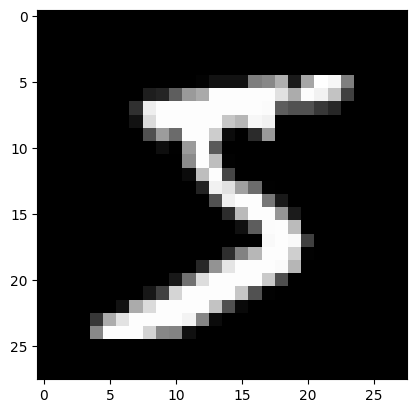

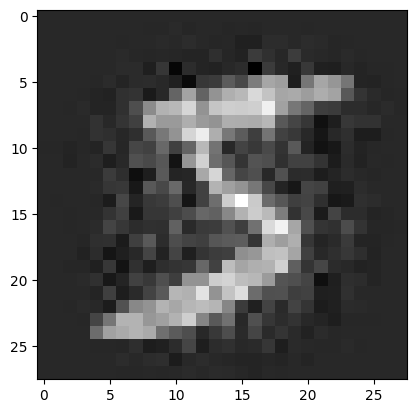

In [21]:
gamma=0.3
plt.imshow(train_images[0,:,:,0]*127.5+127.5, cmap='gray')
plt.show()
plt.imshow(apply_noise(train_images[0:1], tf.constant(gamma))[0,:,:,0]*127.5+127.5, cmap='gray')
plt.show()

# train

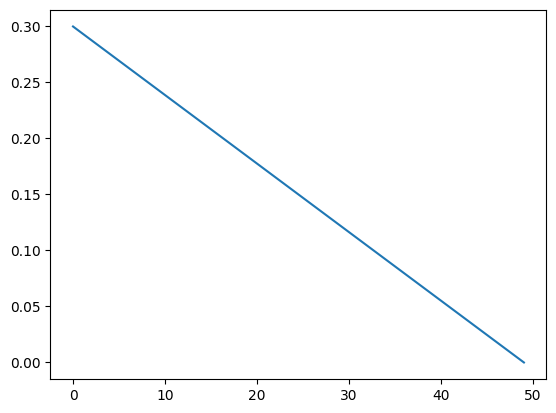

In [11]:
plt.plot(NOISE_RATE_SCHEDULE)

In [22]:
log, sample = train(train_dataset, EPOCH, train_noise_rate_schedule, num_G_sample = 16, seed = SEED)
#log, sample = train(train_dataset, EPOCH, num_G_sample = 16, seed = SEED)

epoch : 1 / time : 6.592178583145142 / g_loss : 0.6943693161010742 / d_loss : 1.3690786361694336
epoch : 2 / time : 2.7646918296813965 / g_loss : 1.016096830368042 / d_loss : 0.9741166234016418
epoch : 3 / time : 2.779289722442627 / g_loss : 1.0149126052856445 / d_loss : 1.0435901880264282
epoch : 4 / time : 2.785766363143921 / g_loss : 0.6639824509620667 / d_loss : 1.4475297927856445
epoch : 5 / time : 2.7907042503356934 / g_loss : 0.7155038714408875 / d_loss : 1.4531149864196777
epoch : 6 / time : 2.7912437915802 / g_loss : 0.7428759932518005 / d_loss : 1.3581702709197998
epoch : 7 / time : 2.800306558609009 / g_loss : 0.7085885405540466 / d_loss : 1.7360832691192627
epoch : 8 / time : 2.8050668239593506 / g_loss : 0.7968411445617676 / d_loss : 1.5307502746582031
epoch : 9 / time : 2.7986104488372803 / g_loss : 0.6347824931144714 / d_loss : 1.5242750644683838
epoch : 10 / time : 2.799557685852051 / g_loss : 1.412785530090332 / d_loss : 0.8552594780921936
epoch : 11 / time : 2.7970588

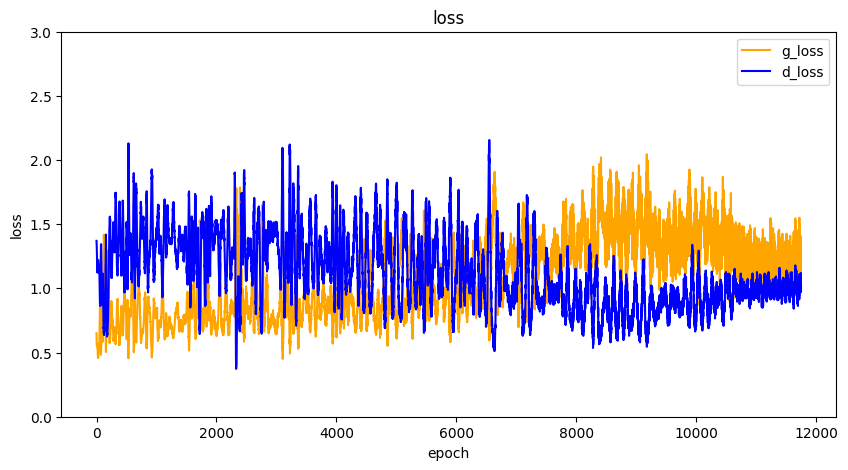

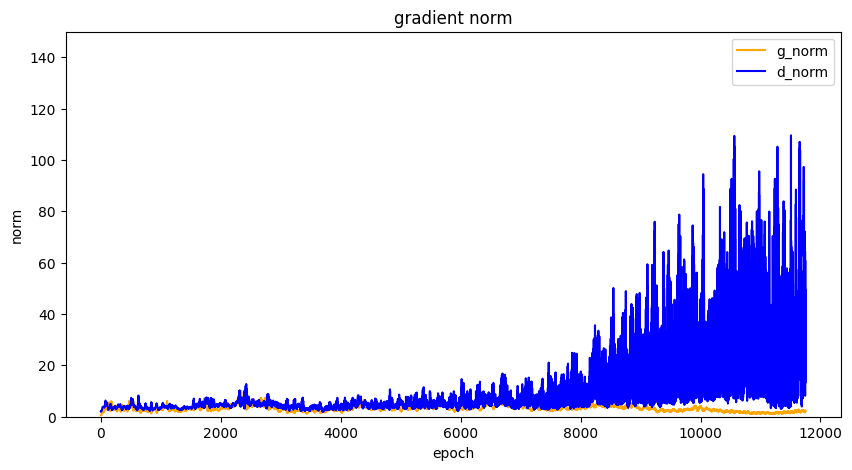

In [23]:
plt.figure(figsize=(10, 5))
plt.ylim(0, 3)
plt.plot(log[0],label="g_loss", color = 'orange')
plt.plot(log[1],label="d_loss", color = 'blue')
plt.title(f'loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.ylim(0, 150)
plt.plot(log[2],label="g_norm", color = 'orange')
plt.plot(log[3],label="d_norm", color = 'blue')
plt.title(f'gradient norm')
plt.xlabel("epoch")
plt.ylabel("norm")
plt.legend()
plt.show()

# sample visualization

## MNIST

In [24]:
for img_set in sample:
  fig = plt.figure(figsize=(4, 4))
  for i in range(img_set.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(img_set[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

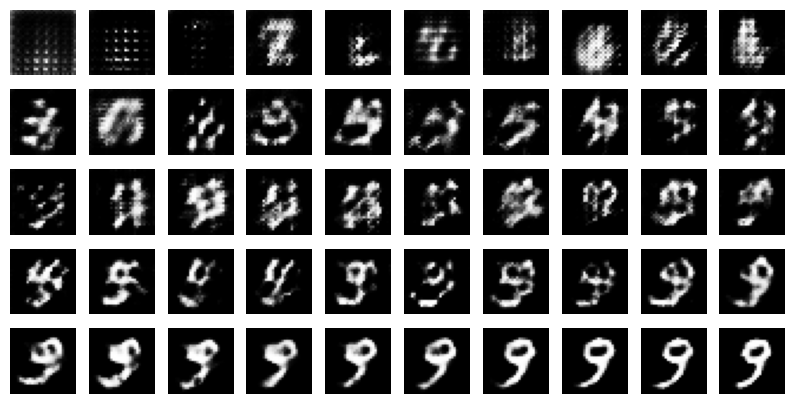

In [26]:
sample_num = 0
start_EPOCH = 0
end_EPOCH = 50

x = 10
y = math.ceil((end_EPOCH - start_EPOCH)/x)
fig = plt.figure(figsize=(x, y))

for i in range(end_EPOCH - start_EPOCH):
  plt.subplot(y, x, i+1)
  plt.imshow((sample[i + start_EPOCH])[sample_num, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
plt.show()


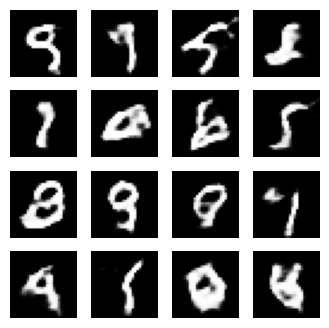

In [29]:
#generate random sample
z=tf.random.normal([16, NOISE_DIM])
test_sample=G(z, training=False)

fig = plt.figure(figsize=(4, 4))
for i in range(test_sample.shape[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(test_sample[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
plt.show()

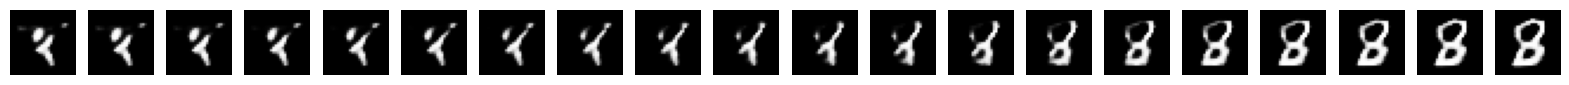

In [32]:
#continuous path from sample A to B
SPLIT = 20   # SPLIT > 1

z_A=tf.random.normal([1, NOISE_DIM])
z_B=tf.random.normal([1, NOISE_DIM])

fig = plt.figure(figsize=(SPLIT, 1))

for i in range(SPLIT):
  z = z_A + (z_B - z_A) * i / (SPLIT-1)
  test_sample = G(z, training=False)
  plt.subplot(1, SPLIT, i+1)
  plt.imshow(test_sample[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
plt.show()